<a href="https://colab.research.google.com/github/UnicodeAnshi/Projects/blob/main/Youtube_comment_Sentiment_analysiis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installing new packaages






In [ ]:
!pip install googletrans
!pip install emoji
!pip install langdetect

##Importing necessary libraries and setting API service



In [ ]:
import csv
import googleapiclient.discovery
from googletrans import Translator
import emoji
import pandas as pd
import string
import re
from langdetect import detect, DetectorFactory
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

SETTING UP API SERVICE

In [ ]:
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = ""
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

# Extracting comments

In [ ]:
def get_comments(video_id, max_comments):
    comments = []
    response = youtube.commentThreads().list(
        part="snippet",
        videoId='OzY2r2JXsDM',
        maxResults=100  # API allows a maximum of 100 results per request
    ).execute()

    while response and len(comments) < max_comments:
        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)
            if len(comments) >= max_comments:
                break

        # Check for nextPageToken
        if 'nextPageToken' in response:
            response = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                pageToken=response['nextPageToken']
            ).execute()
        else:
            break

    return comments

# Extract comments
video_id = "OzY2r2JXsDM"
max_comments = 1000000  # Desired number of comments
#fetching comments
comments = get_comments(video_id, max_comments)

REMOVING PUNCTUATION MARKS

In [ ]:
def remove_punctuation(comment):
    translator = str.maketrans('', '', string.punctuation)
    return comment.translate(translator)

REMOVING LINKS

In [ ]:
def contains_link(comment):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return bool(url_pattern.search(comment))

CONVERTING EMOJI TO TEXT

In [ ]:
def convert_emojis_to_text(text):
    return emoji.demojize(text)

CHECKING IF COMMENT IS IN ENGLISH OR NOT

In [ ]:
def is_english(comment):
    try:
        return detect(comment) == 'en'
    except:
        return False

PREPROCESSING

In [ ]:
translated_comments = []
for comment in comments:
    if not contains_link(comment):
        cleaned_comment = remove_punctuation(comment)
        emoji_converted_comment = convert_emojis_to_text(cleaned_comment)
        leaned_comment = re.sub(r'\d+', '', cleaned_comment)
        if is_english(emoji_converted_comment):
            translated_comments.append(emoji_converted_comment)


In [ ]:
print(f"Number of comments extracted: {len(translated_comments)}")
#converting to file
csv_file="youtube_comments.csv"

with open(csv_file,mode='w',newline='',encoding='utf-8')as file:
    writer= csv.writer(file)
    for comment in translated_comments:
      writer.writerow([comment])
df=pd.read_csv("youtube_comments.csv")

Number of comments extracted: 14485


converting all uppercase letters to lower ones

In [ ]:
df=df.applymap(lambda x: x.lower()if isinstance(x,str)else x)
df.to_csv("youtube_comments.csv",index=False)

READING THE FILE

In [ ]:
df = pd.read_csv('youtube_comments.csv')
df.rename(columns={
    df.columns[0]:'comments'},inplace=True)
print(df.columns)
df = df.replace({'_': ' ', ':': ' '}, regex=True)
# Save the cleaned DataFrame back to a CSV file if needed
df.to_csv('youtube_comments.csv', index=False)

Index(['comments'], dtype='object')


SENTIMENT ANALYSIS USING TEXT BLOB

In [ ]:
df=pd.read_csv('youtube_comments.csv')

#defining a function for sentiment analysis
def getSentiment(text):
  blob=TextBlob(str(text))
  if(blob.sentiment.polarity<0.0):
    return 'negative'
  elif(blob.sentiment.polarity>0.0):
    return 'positive'
  else:
    return 'neutral'

#applying sentiment analysis to comments column
df['sentiment']=df['comments'].apply(getSentiment)
df.to_csv('youtube_comments.csv')
df['sentiment'].value_counts(0)

sentiment
positive    5991
neutral     4596
negative    3928
Name: count, dtype: int64

Encoding target variable

In [ ]:
from sklearn import preprocessing
object =preprocessing.LabelEncoder()
df['sentiment']=object.fit_transform(df['sentiment'])
df['sentiment'].value_counts(0)

sentiment
2    5991
1    4596
0    3928
Name: count, dtype: int64

DECISION TREE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into features (X) and labels (y)
df.dropna(subset=['comments'], inplace=True)
X = df['comments']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#vectorise tree data
clf=DecisionTreeClassifier()
clf.fit(X_train_tfidf,y_train)
y_pred=clf.predict(X_test_tfidf)

#checking accuracy
accuracy=accuracy_score(y_test,y_pred)
accud=accuracy
print("accuracy: ", accuracy)

accuracy:  0.8046848088184636


RANDOM FOREST

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('youtube_comments.csv')
data.dropna(subset=['comments'], inplace=True)

# Split the dataset into features (comments) and target variable (label)
X = data['comments']  # Features
y = data['sentiment']    # Target variable

# Convert text data into numerical format using TF-IDF vectorizer
vectorizer = TfidfVectorizer()  # You can adjust max_features as needed
X = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accurf=accuracy
print("Accuracy:", accuracy)

Accuracy: 0.8101963486048915


RNN

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

df=pd.read_csv("youtube_comments.csv")
df.dropna( inplace=True)
df['comments'] = df['comments'].astype(str)

#tokenise comments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comments'])
X = tokenizer.texts_to_sequences(df['comments'])

#pad ssequences
max_len = 200
X = pad_sequences(X, maxlen=max_len)

#encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=3, activation='softmax'))

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
accur=accuracy
print("Test Accuracy:", accuracy)

Epoch 1/5
91/91 [==============================] - 119s 1s/step - loss: 0.8799 - accuracy: 0.5950 - val_loss: 0.5790 - val_accuracy: 0.7589
Epoch 2/5
91/91 [==============================] - 103s 1s/step - loss: 0.3617 - accuracy: 0.8745 - val_loss: 0.3657 - val_accuracy: 0.8732
Epoch 3/5
91/91 [==============================] - 122s 1s/step - loss: 0.1629 - accuracy: 0.9538 - val_loss: 0.3172 - val_accuracy: 0.8925
Epoch 4/5
91/91 [==============================] - 74s 804ms/step - loss: 0.1014 - accuracy: 0.9730 - val_loss: 0.3249 - val_accuracy: 0.9004
Epoch 5/5
91/91 [==============================] - 5s 56ms/step - loss: 0.3848 - accuracy: 0.8822
Test Accuracy: 0.8821908235549927


GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df=pd.read_csv("youtube_comments.csv")
df.dropna( inplace=True)
df['comments'] = df['comments'].astype(str)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['comments'])
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accug = accuracy_score(y_test, y_pred)
print("accuracy score :",accug)

accuracy score : 0.8070961074750258


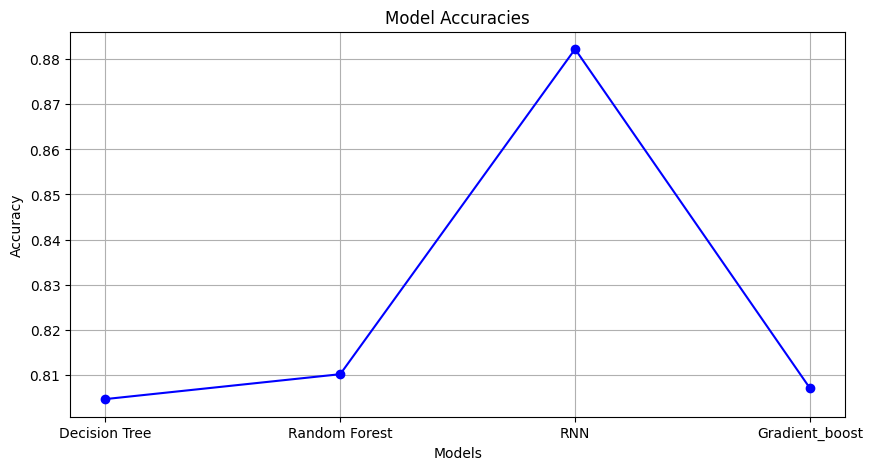

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the accuracies in a dictionary
accuracies = {
    'Decision Tree': accud,
    'Random Forest': accurf,
    'RNN': accur,
    'Gradient_boost':accug
}

models = list(accuracies.keys())
values = list(accuracies.values())

plt.figure(figsize=(10, 5))
plt.plot(models, values, marker='o', linestyle='-', color='b')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.grid(True)
plt.show()
